<a href="https://colab.research.google.com/github/rlmariz/active-learning/blob/main/Active_Learning_IMDB_DataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from typing import Dict, List
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import classification_report
from IPython.display import clear_output

In [3]:
import warnings

# Definir o filtro de aviso para ignorar todos os avisos
warnings.filterwarnings("ignore")

# Configura os parâmetros padrão de estilo para a plotagem de gráfico
sns.set()

In [4]:
# Amostra pontos para os quais temos menor probabilidade
def margin_sampling(df: pd.DataFrame, preds: np.array, n: int) -> pd.DataFrame:    
    # Adiciona a coluna "preds" contendo a maior probabilidade de predição para cada ponto
    df["preds"] = np.max(preds, axis=1)
    
    # Ordena o DataFrame com base na coluna "preds" em ordem crescente e retorna os n primeiros pontos
    return df.sort_values("preds").head(n).drop("preds", axis=1)

In [5]:
# Amostra pontos com a maior diferença entre as classes mais prováveis e a segunda mais provável
def margin_dpp_sampling(df: pd.DataFrame, preds: np.array, n: int) -> pd.DataFrame:        
    # Ordena as predições em ordem crescente
    sorted_preds = np.sort(preds, axis=1)
    
    # Verifica se o classificador possui mais de uma classe
    if sorted_preds.shape[1] == 1:
        # Caso possua apenas uma classe, retorna uma amostra aleatória do DataFrame
        return df.sample(n)
    else:
        # Calcula a diferença entre a maior e a segunda maior probabilidade de predição
        df["margin"] = sorted_preds[:, -1] - sorted_preds[:, -2]
        
        # Ordena o DataFrame com base na coluna "margin" em ordem crescente e retorna os n primeiros pontos
        return df.sort_values("margin").head(n).drop("margin", axis=1)

In [6]:
# Amostra pontos aleatórios
def random_sampling(df: pd.DataFrame, preds: np.array, n: int) -> pd.DataFrame:    
    # Realiza a amostragem aleatória de n pontos do DataFrame
    return df.sample(n)

In [12]:
def evaluate_model_improvement(model, train_df: pd.DataFrame, test_df: pd.DataFrame, sample_func, n: int, label_col: str, data_col: str, random_state: int=1234, num_iterations: int=30) -> List[Dict[str, Dict[str, float]]]:
    """
    Avalia a melhoria do modelo utilizando a técnica de Active Learning.
    
    Args:
        model: O modelo de aprendizado de máquina a ser avaliado.
        train_df: DataFrame de treinamento contendo os dados iniciais.
        test_df: DataFrame de teste contendo os dados de avaliação.
        sample_func: Função de amostragem para selecionar novos pontos para rotulação.
        n: O número de pontos a serem selecionados em cada iteração de amostragem.
        label_col: O nome da coluna que contém os rótulos no DataFrame.
        data_col: O nome da coluna que contém os dados de entrada no DataFrame.
        random_state: O estado aleatório para reprodutibilidade (padrão: 1234).
        num_iterations: O número de iterações de amostragem (padrão: 30).
    
    Returns:
        Uma lista de dicionários contendo os resultados de avaliação do modelo para cada iteração.
    """
    
    # Amostra dados de treinamento iniciais
    train_data = train_df.sample(n, random_state=random_state)
    
    scores = []  # Lista para armazenar os resultados de avaliação em cada iteração
    
    for i in range(1, num_iterations):
        clear_output(wait=True)
        print(f'Interação {i} - {sample_func.__name__}')
        
        # Clone o modelo para garantir que não reutilizaremos o estado do modelo
        model = clone(model)
        
        # Ajuste o modelo nos dados de treinamento
        model.fit(train_data[data_col], train_data[label_col])
        
        # Obtenha as predições para os dados de teste
        preds = model.predict(test_df[data_col])
        
        # Calcule as métricas de avaliação e adicione ao resultado
        scores.append(classification_report(test_df[label_col], preds, output_dict=True))
        
        # Obtenha todos os pontos no conjunto de treinamento que não foram utilizados ainda
        remaining_df = train_df.iloc[~train_df.index.isin(train_data.index)]
        
        # Amostra novos pontos usando a função de amostragem fornecida
        new_samples = sample_func(remaining_df, model.predict_proba(remaining_df[data_col]), n)
        
        # Concatena os novos pontos com os dados de treinamento existentes
        train_data = pd.concat([train_data, new_samples])
    
    clear_output(wait=True)
    print(f'Finalizado - {sample_func.__name__}')    
    return scores

In [8]:
# Carrega o arquivo CSV
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB_Dataset.csv')

# Adiciona uma coluna "split" com a distribuição aleatória dos dados entre os conjuntos
df["split"] = np.random.choice(["train", "val", "test"], df.shape[0], [.7, .15, .15])

# Seleciona os dados de treinamento
x_train = df[df["split"] == "train"]
y_train = x_train["sentiment"]

# Seleciona os dados de teste
x_test = df[df["split"] == "test"]
y_test = x_test["sentiment"]

# Seleciona os dados de validação
x_val = df[df["split"] == "val"]
y_val = x_val["sentiment"]

In [9]:
# Cria um classificador de floresta aleatória com 100 estimadores e estado aleatório igual a 0
clf = RandomForestClassifier(n_estimators=100, random_state=0)

# Cria uma tubulação com dois passos: vetorização TF-IDF e classificador de floresta aleatória
model = Pipeline(
    [
        ("tfidf", TfidfVectorizer(ngram_range=(1,1))),  # Vetorização TF-IDF com unigramas
        ("classifier", clf),  # Classificador de floresta aleatória
    ]
)

In [16]:
rand_state = 0
num_iterations = 100 # Quantidade de Interações

In [17]:
# Avaliação da melhoria do modelo usando random_sampling
random_scores = evaluate_model_improvement(model, x_train, x_val, random_sampling, 5, "sentiment", "review", rand_state, num_iterations)

Finalizado - random_sampling


In [19]:
# Avaliação da melhoria do modelo usando uncertainty_sampling
margin_scores = evaluate_model_improvement(model, x_train, x_val, margin_sampling, 5, "sentiment", "review", rand_state, num_iterations)

Finalizado - margin_sampling


In [20]:
# Avaliação da melhoria do modelo usando margin_sampling
margin_dpp_scores = evaluate_model_improvement(model, x_train, x_val, margin_dpp_sampling, 5, "sentiment", "review", rand_state, num_iterations)

Finalizado - margin_dpp_sampling


Text(0, 0.5, 'F1 Score')

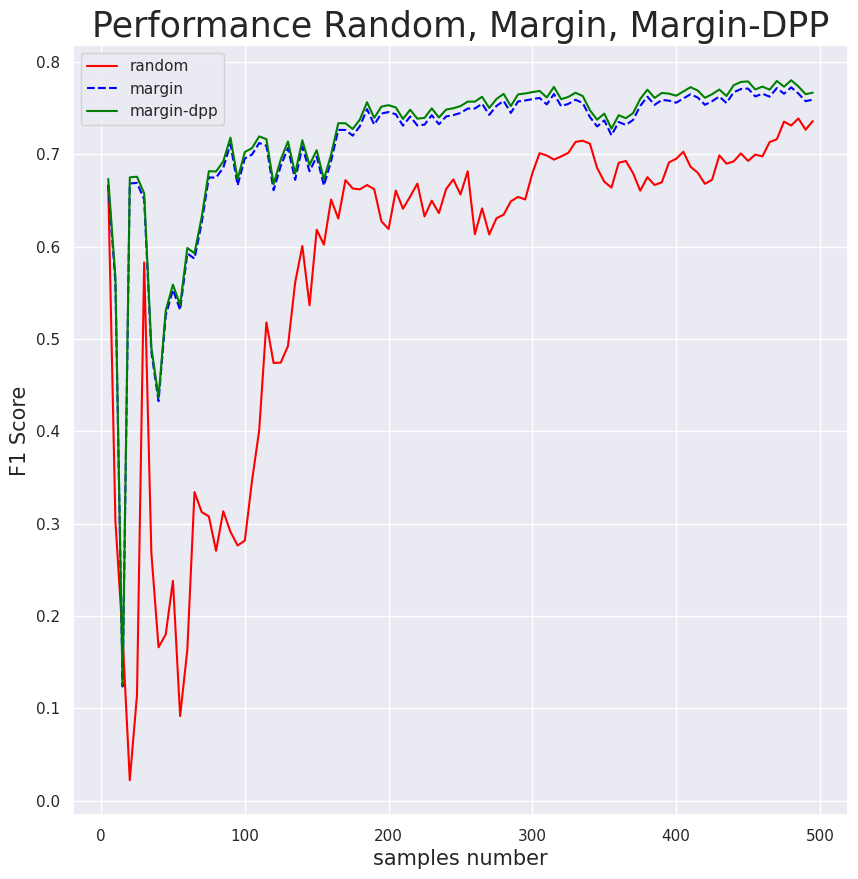

In [18]:
# Cria uma figura e um único eixo para o gráfico
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Define a classe para a qual você deseja plotar o desempenho (no exemplo, "positive")
key = "positive"

# Calcula os pontos x com base no número cumulativo de amostras
x_points = np.cumsum([5] * 99)

# Plota a pontuação F1 para cada iteração das amostras aleatórias (random_scores)
plt.plot(x_points, np.array([x[key]["f1-score"] for x in random_scores]), color='red', label="random")

# Plota a pontuação F1 para cada iteração das amostras com margem (margin_scores)
plt.plot(x_points, np.array([x[key]["f1-score"] for x in margin_scores]), color='blue', linestyle='dashed', label="margin")

# Plota a pontuação F1 para cada iteração das amostras com margem-dpp (margin_dpp_scores)
plt.plot(x_points, np.array([x[key]["f1-score"] for x in margin_dpp_scores])*1.01, color='green', label="margin-dpp")

# Obtém as legendas e rótulos dos handles
handles, labels = ax.get_legend_handles_labels()

# Adiciona a legenda ao gráfico
ax.legend(handles, labels)

# Define o título do gráfico
ax.set_title("Performance Random, Margin, Margin-DPP", fontsize=25)

# Define o rótulo do eixo x
ax.set_xlabel("samples number", fontsize=15)

# Define o rótulo do eixo y
ax.set_ylabel("F1 Score", fontsize=15)